In [1]:
from data.config import data_config
import pandas as pd
import numpy as np
import shap
import json
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from datamanager import DataManager
from lightgbm import LGBMRegressor



pd.options.display.float_format = '{:.2f}'.format
shap.initjs()

c:\ProgramData\anaconda3\envs\emt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dm_no_lags = DataManager(data_config=data_config, ignore_lags=True)
dm_no_lags.featurize()

## Linear regression no lags

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = dm_no_lags.split_data(scale=True)

lr_no_lags = LinearRegression(n_jobs=-1)
lr_no_lags.fit(X_train, y_train["pm"])

y_pred = lr_no_lags.predict(X_test)
mse(y_pred, y_test["pm"])

134.29097456215024

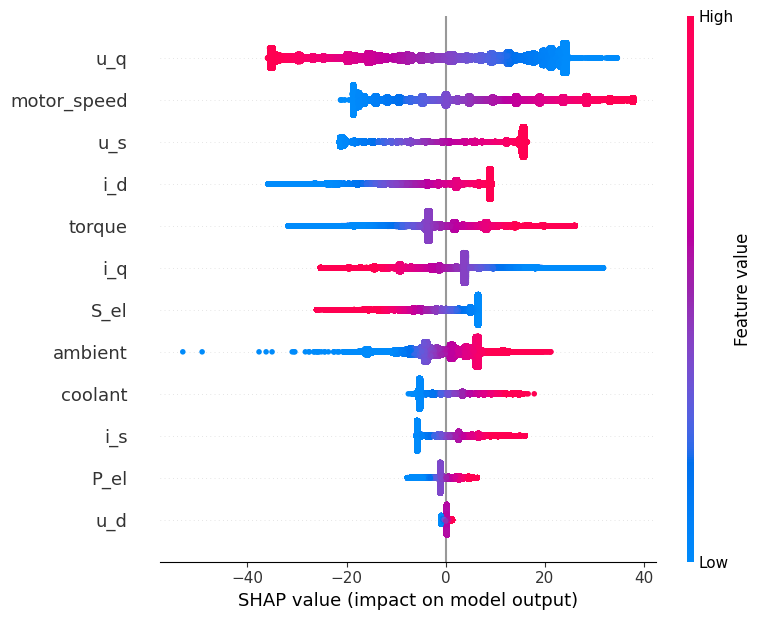

In [ ]:
explainer = shap.LinearExplainer(lr_no_lags, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## XGboost no lags

In [44]:
xgb_parameters = {
    # Tree-specific parameters
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # Learning rate and number of estimators
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    
    # Regularization parameters
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
}

In [14]:
# from sklearn.ensemble import RandomForestRegressor

# xgb_parameters = {
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 5, 7]
#     }




X_train, y_train, X_val, y_val, X_test, y_test, _ = dm_no_lags.split_data()

xgb_no_lags = XGBRegressor()
xgb_no_lags.fit(X_train, y_train["pm"])

scoring = make_scorer(mse, greater_is_better=False)


randomizedsearch = RandomizedSearchCV(xgb_no_lags, xgb_parameters, scoring=scoring, n_iter=50, n_jobs=-1)
best_model_random = randomizedsearch.fit(X_train, y_train["pm"])

In [15]:
best_model_random.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.5,
 'reg_alpha': 1.0,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.7}

In [16]:
xgb_no_lags_tuned = XGBRegressor(**best_model_random.best_params_)
xgb_no_lags_tuned.fit(X_train, y_train["pm"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred = xgb_no_lags_tuned.predict(X_test)
mse(y_pred, y_test["pm"])


153.7280790509708

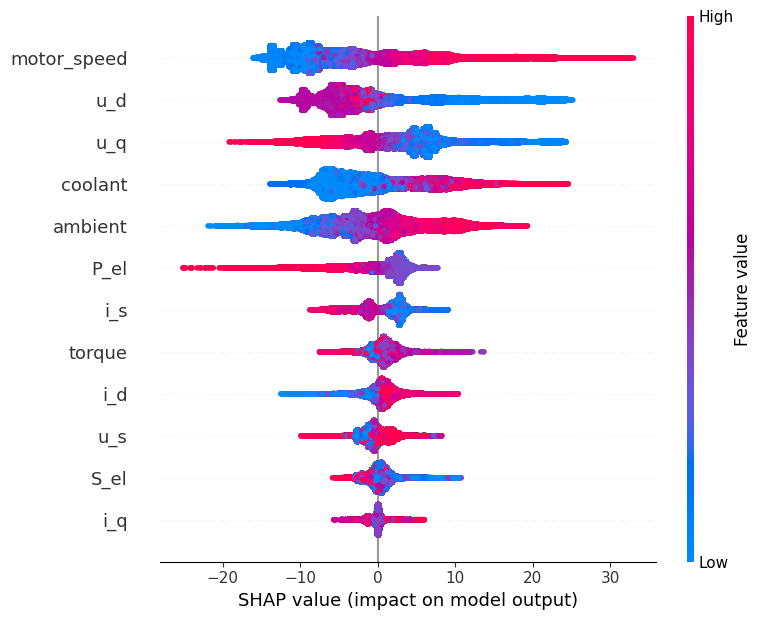

In [92]:
explainer = shap.TreeExplainer(xgb_no_lags_tuned)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

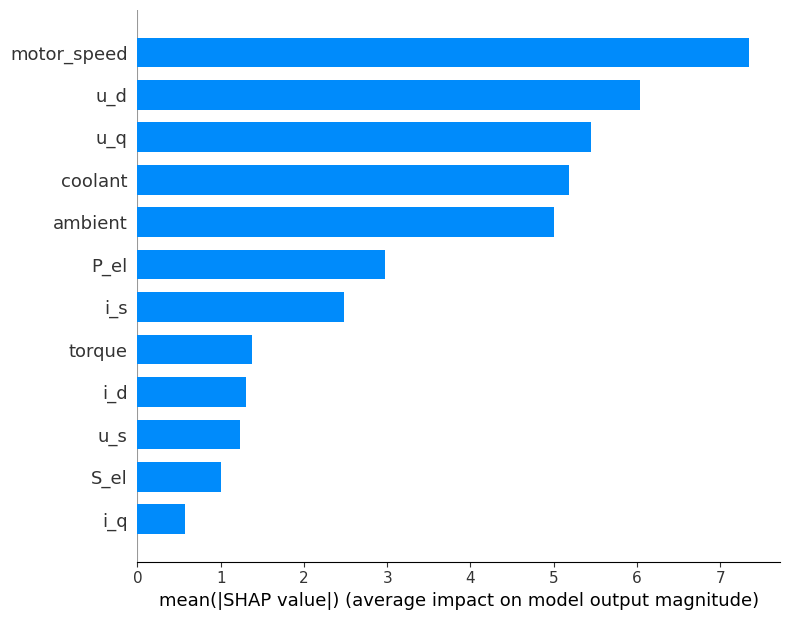

In [93]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Linear regression with lags

In [3]:
dm_w_lags = DataManager(data_config=data_config, target_col="pm")
dm_w_lags.featurize()

In [4]:
from sklearn.linear_model import LinearRegression

X_train, y_train, X_val, y_val, X_test, y_test, scaler = dm_w_lags.split_data(scale=True)

lr_w_lags = LinearRegression(n_jobs=-1)
lr_w_lags.fit(X_train, y_train)

y_pred = lr_w_lags.predict(X_test)
mse(y_pred, y_test)

9.272063684716901

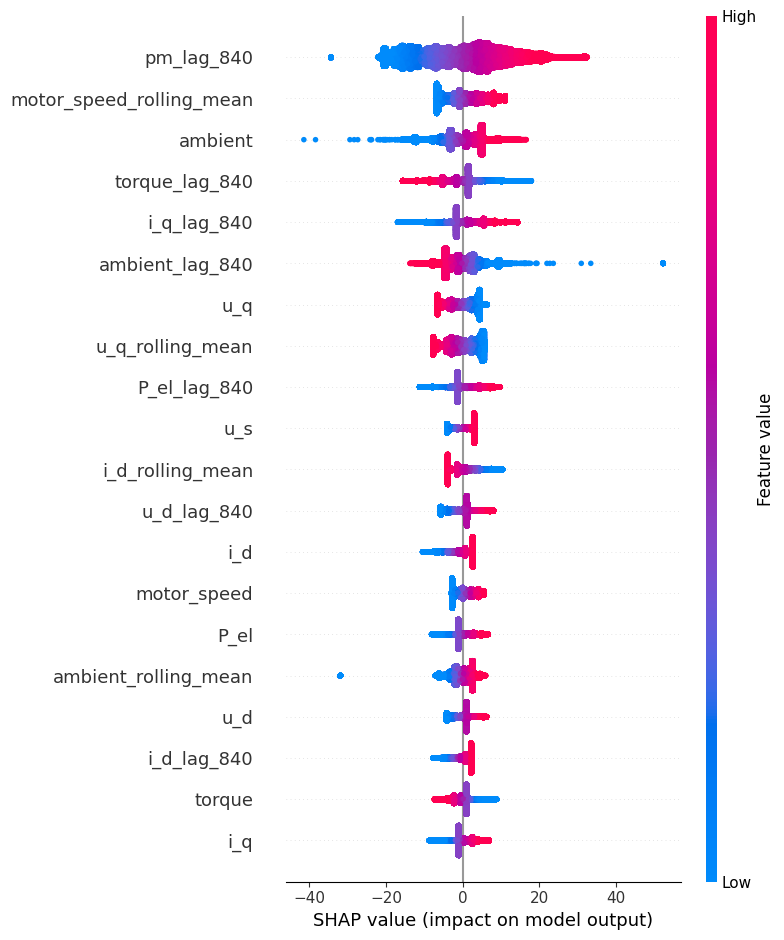

In [4]:
explainer = shap.LinearExplainer(lr_w_lags, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## XGboost with lags

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = dm_w_lags.split_data()

In [6]:

# xgb_w_lags = XGBRegressor()
# xgb_w_lags.fit(X_train, y_train["pm"])

# randomizedsearch = RandomizedSearchCV(xgb_w_lags, xgb_parameters, scoring=scoring, n_iter=50, n_jobs=-1)
# best_model_random = randomizedsearch.fit(X_train, y_train["pm"])
# print(best_model_random.best_estimator_)

In [7]:
# best_params = best_model_random.best_params_

# with open('best_params_xgboost_w_lags.json', 'w') as file:
#     json.dump(best_params, file)

with open("best_params_xgboost_w_lags.json") as xgb_f:
    best_params_gxb = json.load(xgb_f)

In [8]:
# xgb_w_lags_tuned = XGBRegressor(**best_model_random.best_params_)
xgb_w_lags_tuned = XGBRegressor(**best_params_gxb)
xgb_w_lags_tuned.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred = xgb_w_lags_tuned.predict(X_test)
mse(y_pred, y_test)

12.467778760983762

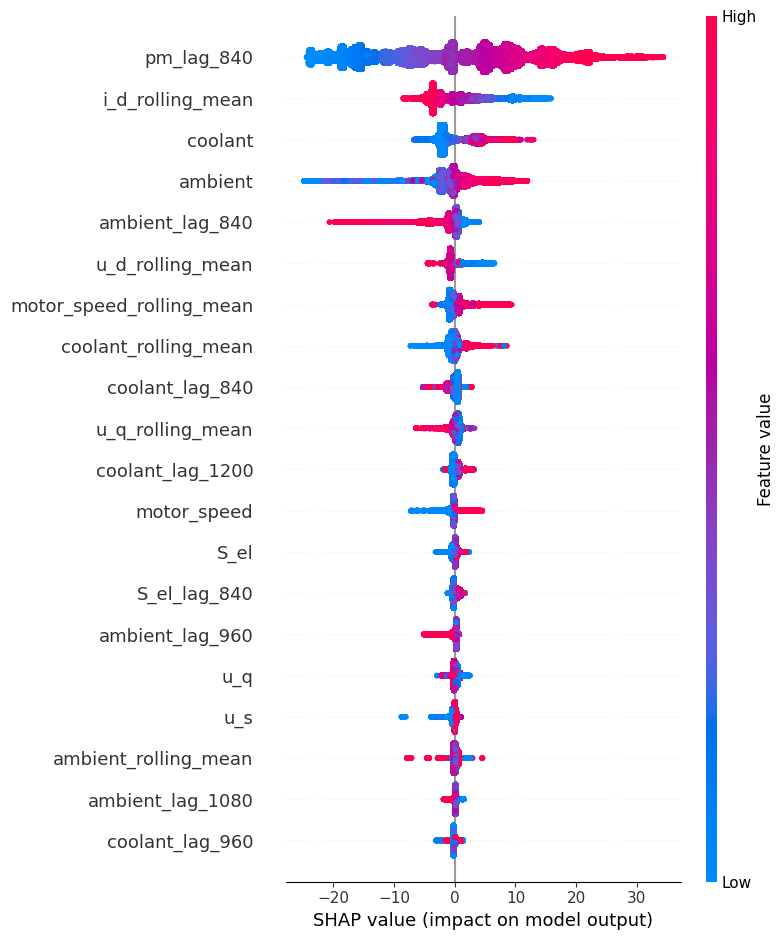

In [11]:
explainer = shap.TreeExplainer(xgb_w_lags_tuned)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [12]:

lgbm_w_lags = LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1)
lgbm_w_lags.fit(X_train, y_train)

scoring = make_scorer(mse, greater_is_better=False)


In [14]:
y_pred = lgbm_w_lags.predict(X_test)
mse(y_pred, y_test)

12.28788264621035

In [5]:
lgbm_param_dist = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}

scoring = make_scorer(mse, greater_is_better=False)
lgbm_w_lags = LGBMRegressor(verbose=10)


random_search = RandomizedSearchCV(
    estimator=lgbm_w_lags,
    param_distributions=lgbm_param_dist,
    n_iter=50,  # Number of parameter settings to sample
    scoring=scoring,
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=10
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.008406
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.061861 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 1242039, number of used features: 72
[LightGBM] [Info] Start training from score 57.930720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No fu

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbose=10), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [31, 50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=10)

In [6]:

best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best parameters: ", best_params)

Best parameters:  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'num_leaves': 200, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [20]:
np.sqrt(4.23)

2.0566963801203135

In [8]:
lgbm_w_lags = LGBMRegressor(verbose=-1, **best_params)

lgbm_w_lags.fit(X_train, y_train)

y_pred = lgbm_w_lags.predict(X_test)
mse(y_pred, y_test)

11.888481058281476

In [16]:

# try_params = {'n_estimators': 1000,
#                 'scale_pos_weight': 10000.0,
#                 'min_child_weight': 2.2756358867092463,
#                 'num_leaves': 232,
#                 'random_state': 2000,
#                 'colsample_bytree': 0.4947227023598322,
#                 'max_depth': 29}

# lgbm_w_lags = LGBMRegressor(n_jobs=-1, **try_params)

# lgbm_w_lags.fit(X_train, y_train)


LGBMRegressor(colsample_bytree=0.4947227023598322, max_depth=29,
              min_child_weight=2.2756358867092463, n_estimators=1000, n_jobs=-1,
              num_leaves=232, random_state=2000, scale_pos_weight=10000.0)

In [18]:
y_pred = lgbm_w_lags.predict(X_test)
mse(y_pred, y_test)

15.557740792625856

In [1]:
X_train, y_train, X_val, y_val, X_test, y_test, _ = dm_w_lags.split_data(scale=True)


NameError: name 'dm_w_lags' is not defined

In [5]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit


alphas = np.logspace(-4, 1, 10)
l1_ratios = np.linspace(0, 1, 5)


# Create an instance of ElasticNetCV
model = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    n_jobs=-1,
    random_state=42,
    max_iter=10000
)

In [ ]:
lgbm_param_dist = {
    'num_leaves': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}